Ryan Dougherty - 606085269

In [2]:
from qiskit import *
from qiskit.circuit import Parameter,ParameterVector, Gate
from qiskit.quantum_info import Operator
from qiskit.circuit.library import *
from qiskit.visualization import array_to_latex, plot_histogram
from qutip import hilbert_dist, Qobj, fock_dm

import random

import pyswarms as ps
import pyswarms.backend as P
from pyswarms.backend.topology import Star

from scipy.optimize import minimize

import numpy as np
import matplotlib.pyplot as plt

## Introduction

To optimize a generic 3 qubit unitary, we can build it using a set of generic rotation gates composed of 11 single qubit unitaries and 4 two qubit unitaries. This process is outlined in the paper 'Optimal Implementation of Quantum Gates with Two Controls:
A Detailed Proof' by Jens Palsberg and Nengkun Yu. In this assignement we used the methods in this paper to find an approximiate solution to the Toffoli gate (CCNOT) using only 4 two qubit gates. I was able to measure how close my generated Toffoli gate was to the original by comparing it to the Hilbert Schmidt distance which is outlined later.

## The Toffoli Gate and the Hilbert Schmidt Distance
Here's the native Toffoli gate from qiskit:

In [3]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
ccx_gate = Operator(qc).data
array_to_latex(ccx_gate)

<IPython.core.display.Latex object>

## Hilbert Schmidt Distance

Next steps is to to have a function to measure the 'closeness' to an approximate matrix. This can be done simply with the Hilbert Schmidt Distance. This is given by the following fromula from Jens' paper 'Approximate Quantum Computing':

$$d(U,V) = \sqrt{1-\frac{\|Tr(U^{\dagger}V)\|^2}{N^2}}$$

Where $Tr(U)$ is the trace of U and $N=2^n$. This will give us the absolute value of the Hilbert Schmidt distance (a real value), which will be eaasy to optimize around. I've defined this function below in `my_hilbert_schmidt_distance`. I've also defined an additional function `get_hilbert_shmidt_distance` which returns the 2d imaginary Hilbert Schmidt distance. This definition comes from the qutip library and I use it later to do some further optimization.

In [4]:
def get_hilbert_shmidt_distance(gate1, gate2):
    return hilbert_dist(Qobj(gate1), Qobj(gate2))

def my_hilbert_schmidt_distance(gate1, gate2):
    return np.sqrt(1 - (np.abs(np.trace(np.conj(gate1).T @ gate2))**2) / (2**3)**2)

In [5]:
print("Hilbert Schmidt Distance of CCX with itself: ", get_hilbert_shmidt_distance(ccx_gate, ccx_gate))
print("My Hilbert Schmidt Distance of CCX with itself: ", my_hilbert_schmidt_distance(ccx_gate, ccx_gate))

Hilbert Schmidt Distance of CCX with itself:  0.0
My Hilbert Schmidt Distance of CCX with itself:  0.0


## Building the Circuit
We can build the circuit with 11 single qubit gates which can simply be made with qiskit's UGate. This is a generic rotation matrix of three dimensions defined by:

In [6]:
class SingleQubitU(Gate):
    def __init__(self, theta, phi, lam):
        super().__init__('U1', 1, [theta, phi, lam])
    
    def _define(self):
        qc = QuantumCircuit(1)
        qc.unitary(self.to_matrix(), [0])
        self.definition = qc
    
    def to_matrix(self):
        theta = float(self.params[0])
        phi = float(self.params[1])
        lam = float(self.params[2])
        return UGate(theta, phi, lam).to_matrix()

Next, we can define a generic two qubit unitary using RXX, RYY, and RZZ gates like so:

In [7]:
class TwoQubitU(Gate):
    def __init__(self, alpha1, alpha2, alpha3):
        super().__init__('U2', 2, [alpha1, alpha2, alpha3])
    def _define(self):
        qc = QuantumCircuit(2)
        qc.unitary(self.to_matrix(), [0, 1])
        self.definition = qc
    def to_matrix(self):
        alpha1 = float(self.params[0])
        alpha2 = float(self.params[1])
        alpha3 = float(self.params[2])

        rxx_gate = RXXGate(alpha1).to_matrix()
        ryy_gate = RYYGate(alpha2).to_matrix()
        rzz_gate = RZZGate(alpha3).to_matrix()

        return rxx_gate @ ryy_gate @ rzz_gate

In [8]:
class ParamVectorItterator:
    def __init__(self, param_vector):
        self.param_vector = param_vector
        self.index = 0
    def __iter__(self):
        return self
    def __next__(self):
        if self.index < len(self.param_vector):
            start = self.index
            end = self.index + 3
            params = self.param_vector[start:end]
            self.index += 3
            return params
        else:
            raise StopIteration

From the paper, we know its possible to build a generic gate with 4 two qubit unitaries in the order $U_{AB}U_{BC}U_{AB}U_{AC}$. We then surround the space around the 4 unitaries with 11 single qubit unitaries. The circuit is outlined below. Each Unitary has a set of 3 rotation parameters assigned to them, allowing for a total of 45 degrees of freedom.

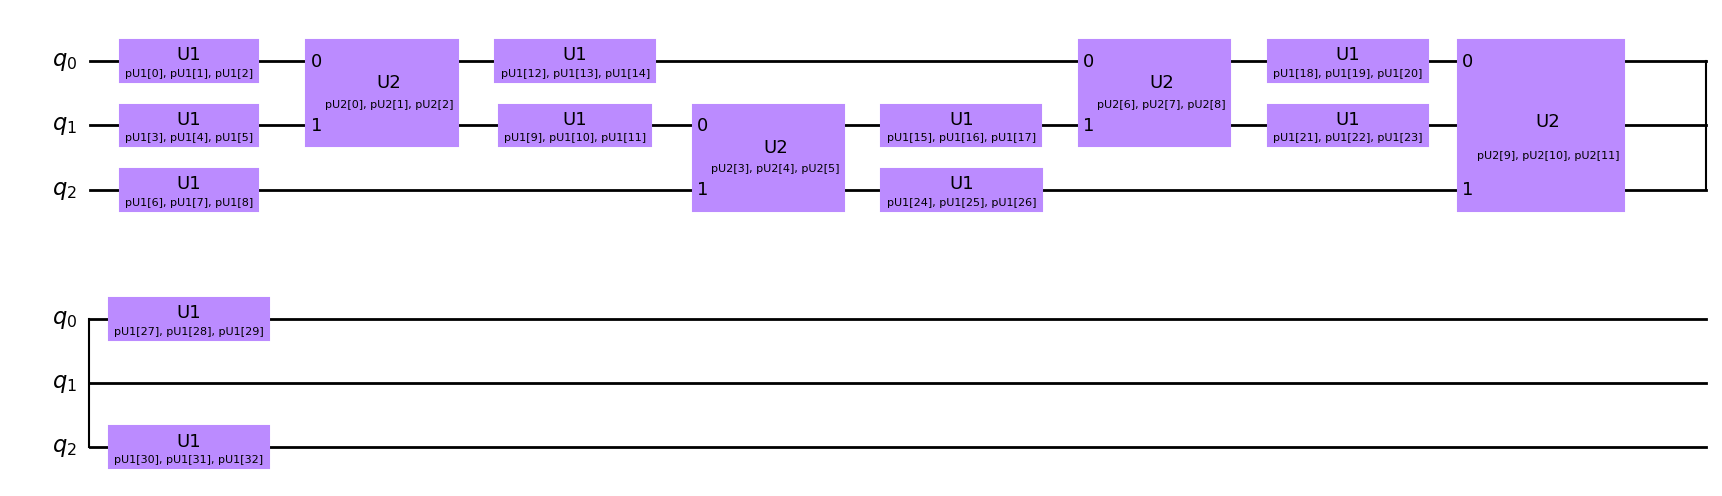

In [10]:
approx_CCNOT_qc = QuantumCircuit(3, name="Approx CCNOT")

# Define parameters
theta = Parameter('theta')
phi = Parameter('phi')
lam = Parameter('lam')

num_U1_params = 3 * 11
num_U2_params = 3 * 4

pU1 = ParameterVector('pU1', num_U1_params)
pU1_itter = ParamVectorItterator(pU1)
pU2 = ParameterVector('pU2', num_U2_params)
pU2_itter = ParamVectorItterator(pU2)

# Create the circuit
approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [0])
approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [1])
approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [2])

approx_CCNOT_qc.append(TwoQubitU(*next(pU2_itter)), [0, 1])

approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [1])

approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [0])
approx_CCNOT_qc.append(TwoQubitU(*next(pU2_itter)), [1, 2])

approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [1])

approx_CCNOT_qc.append(TwoQubitU(*next(pU2_itter)), [0, 1])

approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [0])
approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [1])
approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [2])

approx_CCNOT_qc.append(TwoQubitU(*next(pU2_itter)), [0, 2])

approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [0])
approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [2])

approx_CCNOT_qc.draw(output='mpl')

## Finding a Solution Using Swarm Optimization
We need to find a set of parameters that will closely approximate a Toffoli using this circuit. An algorithm I've chosen to use is Swarm Optimization. A detailed description of the algorithm can be found here: https://machinelearningmastery.com/a-gentle-introduction-to-particle-swarm-optimization/

In a nutshell, it uses a randomly distributed amount of points that query the function. They all move about the inout space and have the ability to 'talk' to eachother, where if one particle finds a global minimum, it'll tell the rest. This causes nearby particles to 'swarm' towards it. The grouped up particles will repeatedly swarm about the current global minimum until they unconver an even smaller minimum. Then the process is repeated.

In [11]:
def opt_func(vals):
    distances = []
    for p in vals:
        # Get the circuit
        bound_approx_CCNOT = approx_CCNOT_qc.bind_parameters({pU1: p[:num_U1_params], pU2: p[num_U1_params:]})

        # Get the matrix
        approx_CCNOT_matrix = Operator(bound_approx_CCNOT).data

        # Get the distance
        hs_distance = get_hilbert_shmidt_distance(ccx_gate, approx_CCNOT_matrix)

        abs_hs_distance = np.abs(hs_distance.real) + np.abs(hs_distance.imag)
        distances.append(abs_hs_distance)

    return distances

In [16]:
def opt_func_minimize(vals):
    # Get the circuit
    bound_approx_CCNOT = approx_CCNOT_qc.bind_parameters({pU1: vals[:num_U1_params], pU2: vals[num_U1_params:]})

    # Get the matrix
    approx_CCNOT_matrix = Operator(bound_approx_CCNOT).data

    # Get the distance
    hs_distance = get_hilbert_shmidt_distance(ccx_gate, approx_CCNOT_matrix)

    abs_hs_distance = np.abs(hs_distance.real) + np.abs(hs_distance.imag)
    return abs_hs_distance


Here I use the `opt_func` defined above and run swarm optimization using the python library Pyswarms. I've choesn my c1 parameter to be 0.5 and my c2 parameter to be 0.3. The algorithm contains 200 particles and is set to run for 2500 iterations. I had all the variables bounded between 0 and $2\pi and they all started at random values.

In [12]:
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
bounds = (np.repeat(0, num_U1_params + num_U2_params), np.repeat(2*np.pi, num_U1_params + num_U2_params))
optimizer = ps.single.GlobalBestPSO(n_particles=250, dimensions=num_U1_params + num_U2_params, options=options, bounds=bounds)
cost_init, pos_init = optimizer.optimize(opt_func, iters=2000)

print("Total cost: ", cost_init)
print("Best position: ", pos_init)

2023-03-01 17:54:01,284 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |2/2000, best_cost=2.65


KeyboardInterrupt: 

In [18]:
# x0= [[0.80935757 4.03064928 3.99945074 3.58218358 4.36237669 1.39321919
#  3.33812644 4.41750011 5.34766194 5.0108509  4.31427562 2.55189299
#  3.29670679 0.27385438 3.29696433 4.04704062 4.72576305 1.97151616
#  2.7688676  3.4759589  1.38288517 3.32849963 5.13397885 5.64837988
#  4.53649103 3.67736304 2.31726436 5.09984103 3.74299566 2.71574929
#  3.79234352 1.69621877 1.90593825 4.47350015 3.61434907 3.92042023
#  5.83847698 2.06351365 2.371979   4.21090831 0.91852663 3.54680939
#  0.10755075 5.54178268 2.93166768]]

res = minimize(opt_func_minimize, np.repeat(0, num_U1_params + num_U2_params))
print(res)

KeyboardInterrupt: 

In [1]:
# Saving the best position thus far
best_pos_thus_far = pos_init

NameError: name 'pos_init' is not defined

## Results
As we can see, the swarm optimization did quite well. I was able to achieve a HS distance of 0.428 - which is relatively close to the accepted minimum of $\approx 0.38$. Let's take a look at the output matrix.

In [29]:
def pos_to_matrix(pos):
    bound_approx_CCNOT = approx_CCNOT_qc.bind_parameters({pU1: pos[:num_U1_params], pU2: pos[num_U1_params:]})
    approx_CCNOT_matrix = Operator(bound_approx_CCNOT).data
    return approx_CCNOT_matrix

In [30]:
print(get_hilbert_shmidt_distance(pos_to_matrix(best_pos_thus_far), ccx_gate))

(-0.006069049415235672+0.0016431836551709378j)


In [31]:
print(my_hilbert_schmidt_distance(pos_to_matrix(best_pos_thus_far), ccx_gate))

0.9417119513890031


In [32]:
array_to_latex(pos_to_matrix(best_pos_thus_far))

<IPython.core.display.Latex object>

As we can see, this matrix is quite good. All of the positions where we expect to see 1s are values very close to such.

## Attempt at Further Optimization

This matrix is quite good. However, we could optimize it to get a bit closer.

To start, lets consider the imaginary version of the Hilbert Schmidt Distance; which is of course 2-dimentional

In [16]:
qutip_hs_dist = get_hilbert_shmidt_distance(ccx_gate, Operator(bound_approx_CCNOT).data)
print(qutip_hs_dist)

NameError: name 'bound_approx_CCNOT' is not defined

Now, lets plot the HS distance on a polar plot centered around zero

(-30.0, 30.0)

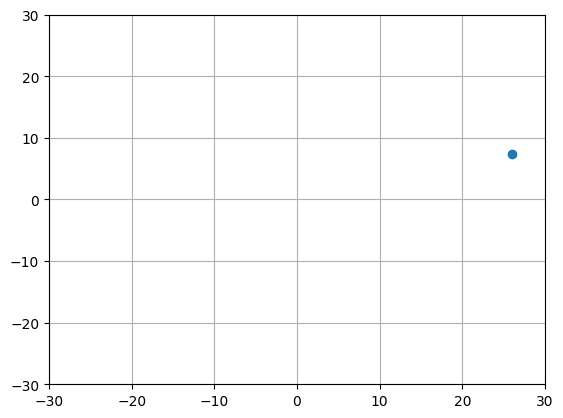

In [185]:
plt.scatter([qutip_hs_dist.real], [qutip_hs_dist.imag])
plt.grid()
plt.xlim([-30, 30])
plt.ylim([-30, 30])

Lets choose 3 points we can optimize around. Here they are at pi/4, 3pi/4 and 3pi/2

(-30.0, 30.0)

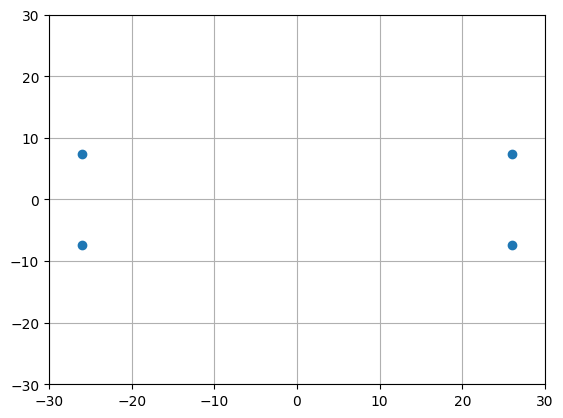

In [192]:
opt_point1 = -qutip_hs_dist.real + qutip_hs_dist.imag * 1j
opt_point2 =  qutip_hs_dist.real - qutip_hs_dist.imag * 1j
opt_point3 = -qutip_hs_dist.real - qutip_hs_dist.imag * 1j

plt.scatter([qutip_hs_dist.real, opt_point1.real, opt_point2.real, opt_point3.real], [qutip_hs_dist.imag, opt_point1.imag, opt_point2.imag, opt_point3.imag])
plt.grid()
plt.xlim([-30, 30])
plt.ylim([-30, 30])

If we can possibly optimize a set of matrices centered around *different* points. Then we can use approximate computation (similar to QUEST) by calculating an average matrix of all of them. 

Lets define a new optimization function that takes in a shifted value from the HS distance. Then we perform swam optimization once more on each of these shifted distances

In [197]:
def opt_func_shift(vals, center):
    distances = []
    for p in vals:
        # Get the circuit
        bound_approx_CCNOT = approx_CCNOT_qc.bind_parameters({pU1: p[:num_U1_params], pU2: p[num_U1_params:]})

        # Get the matrix
        approx_CCNOT_matrix = Operator(bound_approx_CCNOT).data

        # Get the distance
        distances.append(get_hilbert_shmidt_distance(ccx_gate, approx_CCNOT_matrix) + center)

    return  distances

In [198]:
def swarm(center_point, num_particles=100, num_iters=1000):
    options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
    bounds = (np.repeat(0, num_U1_params + num_U2_params), np.repeat(2*np.pi, num_U1_params + num_U2_params))
    optimizer = ps.single.GlobalBestPSO(n_particles=num_particles, dimensions=num_U1_params + num_U2_params, options=options, bounds=bounds)
    cost, pos = optimizer.optimize(opt_func_shift, iters=num_iters, center=center_point)
    return cost, pos

In [199]:
cost_pos1, pos_pos1 = swarm(opt_point1, num_particles=100, num_iters=1000)
cost_pos2, pos_pos2 = swarm(opt_point2, num_particles=100, num_iters=1000)
cost_pos3, pos_pos3 = swarm(opt_point3, num_particles=100, num_iters=1000)

2023-02-25 13:40:58,833 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-28.6+8.89j
2023-02-25 13:54:39,961 - pyswarms.single.global_best - INFO - Optimization finished | best cost: (-28.599308497278976+8.886321420399561j), best pos: [3.58811598 2.0177183  5.15115218 5.1228291  4.61921616 2.46612764
 3.73603982 4.28436479 3.66687865 4.2760522  3.13186055 5.04507014
 3.1001058  3.01776624 2.38249799 5.67406341 2.42025585 3.8929401
 4.36026617 3.12554758 3.83618111 4.82730524 2.7452311  3.56244069
 2.96814722 0.77365847 1.93035488 3.55897302 2.49046794 3.20206162
 1.49651518 2.75932079 4.36336892 4.81269027 3.40910368 1.70397248
 1.54160605 4.43838542 1.17572532 2.39587676 2.79598301 5.58771347
 4.41281812 1.46948093 2.76557057]
2023-02-25 13:54:39,989 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.glo

In [200]:
tot_cost_pos1 = cost_pos1-opt_point1
tot_cost_pos2 = cost_pos2-opt_point2
tot_cost_pos3 = cost_pos3-opt_point3
print(tot_cost_pos1)

(-2.617449505363499+1.4956251835351022j)


(-30.0, 30.0)

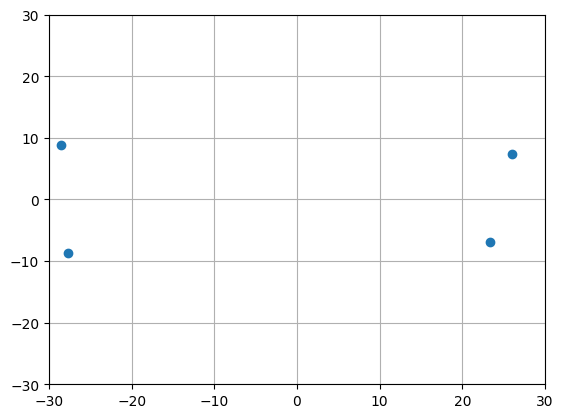

In [202]:
#plt.polar([0, np.angle(cost_pos1)], [0, np.abs(cost_pos1)], marker='o')
# plt.polar([0, np.angle(cost_pos1), 0, np.angle(cost_pos2),0,np.angle(cost_pos3)], [0, np.abs(cost_pos1), 0, np.abs(cost_pos2),0,np.abs(cost_pos3)], marker='o')
plt.scatter([qutip_hs_dist.real, cost_pos1.real, cost_pos2.real, cost_pos3.real], [qutip_hs_dist.imag, cost_pos1.imag, cost_pos2.imag, cost_pos3.imag])
plt.grid()
plt.xlim([-30, 30])
plt.ylim([-30, 30])

In [203]:
array_to_latex(pos_to_matrix(pos_pos1))

<IPython.core.display.Latex object>

In [204]:
array_to_latex(pos_to_matrix(pos_pos2))

<IPython.core.display.Latex object>

In [205]:
array_to_latex(pos_to_matrix(pos_pos3))

<IPython.core.display.Latex object>

In [210]:
average_mat = (pos_to_matrix(pos_init) + pos_to_matrix(pos_pos1) + pos_to_matrix(pos_pos2) + pos_to_matrix(pos_pos3)) / 4
array_to_latex(average_mat)

<IPython.core.display.Latex object>

In [211]:
get_hilbert_shmidt_distance(ccx_gate, average_mat)

(3.4242954988095855+2.4601458482469236j)

In [212]:
my_hilbert_schmidt_distance(ccx_gate, average_mat)

0.9522955023748987